In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# import train test split fromo sklearn
from sklearn.model_selection import train_test_split

In [6]:
dane = pd.read_excel('/Users/adammajczyk/Dokumenty-lokalne/DANE/online_retail_II.xlsx')

In [7]:
dane.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [10]:
#split data in train test validation 0.8 0.1 0.1
train, test = train_test_split(dane, test_size=0.2)
train, val = train_test_split(train, test_size=0.125)


In [11]:
train

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
365626,524843,20979,36 PENCILS TUBE RED RETROSPOT,16,2010-09-30 18:12:00,1.25,16044.0,United Kingdom
45912,493568,21667,GLASS CAKE COVER AND PLATE,2,2010-01-05 09:16:00,16.95,16875.0,United Kingdom
124305,501278,21975,PACK OF 60 DINOSAUR CAKE CASES,2,2010-03-15 14:01:00,0.55,17180.0,United Kingdom
265368,C515014,M,Manual,-1,2010-07-07 16:32:00,1588.51,15581.0,United Kingdom
41115,492783,20655,QUEEN OF SKIES LUGGAGE TAG,1,2009-12-18 17:15:00,2.57,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
385615,526424,20971,PINK BLUE FELT CRAFT TRINKET BOX,12,2010-10-11 15:01:00,1.25,16477.0,United Kingdom
140904,502842,21889,WOODEN BOX OF DOMINOES,4,2010-03-28 13:31:00,1.25,17518.0,United Kingdom
298801,518482,85066,CREAM SWEETHEART MINI CHEST,6,2010-08-09 12:24:00,12.75,13488.0,United Kingdom
231155,511778,21624,VINTAGE UNION JACK DOORSTOP,3,2010-06-10 12:37:00,5.95,17716.0,United Kingdom


In [12]:

train['Month'] = train['InvoiceDate'].dt.month
train['Year'] = train['InvoiceDate'].dt.year
train['Day'] = train['InvoiceDate'].dt.day
train['Hour'] = train['InvoiceDate'].dt.hour
train['Minute'] = train['InvoiceDate'].dt.minute
train['Second'] = train['InvoiceDate'].dt.second
train['Price'] = train['Price'].astype(float)
train['Quantity'] = train['Quantity'].astype(float)
train['TotalPrice'] = train['Price'] * train['Quantity']

train.head()


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Month,Year,Day,Hour,Minute,Second,TotalPrice
365626,524843,20979,36 PENCILS TUBE RED RETROSPOT,16.0,2010-09-30 18:12:00,1.25,16044.0,United Kingdom,9,2010,30,18,12,0,20.00
45912,493568,21667,GLASS CAKE COVER AND PLATE,2.0,2010-01-05 09:16:00,16.95,16875.0,United Kingdom,1,2010,5,9,16,0,33.90
124305,501278,21975,PACK OF 60 DINOSAUR CAKE CASES,2.0,2010-03-15 14:01:00,0.55,17180.0,United Kingdom,3,2010,15,14,1,0,1.10
265368,C515014,M,Manual,-1.0,2010-07-07 16:32:00,1588.51,15581.0,United Kingdom,7,2010,7,16,32,0,-1588.51
41115,492783,20655,QUEEN OF SKIES LUGGAGE TAG,1.0,2009-12-18 17:15:00,2.57,NaN,United Kingdom,12,2009,18,17,15,0,2.57


In [79]:
import pycountry_convert

# create a mapping between countries and continents

coutnries = train.Country.unique()
country_continent = {}
for country in coutnries:
    try:
        #country name to country code
        code = pycountry_convert.country_name_to_country_alpha2(country)
        #country code to continent
        continent  =pycountry_convert.country_alpha2_to_continent_code(code)

        country_continent[country] = continent
    except KeyError:
        continue

# create a new column with the continent for each row
train['Continent'] = train['Country'].map(country_continent)


In [80]:
train.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Month,Year,Day,Hour,Minute,Second,TotalPrice,YearMonth,Continent
365626,524843,20979,36 PENCILS TUBE RED RETROSPOT,16.0,2010-09-30 18:12:00,1.25,16044.0,United Kingdom,9,2010,30,18,12,0,20.00,2010-9,EU
45912,493568,21667,GLASS CAKE COVER AND PLATE,2.0,2010-01-05 09:16:00,16.95,16875.0,United Kingdom,1,2010,5,9,16,0,33.90,2010-1,EU
124305,501278,21975,PACK OF 60 DINOSAUR CAKE CASES,2.0,2010-03-15 14:01:00,0.55,17180.0,United Kingdom,3,2010,15,14,1,0,1.10,2010-3,EU
265368,C515014,M,Manual,-1.0,2010-07-07 16:32:00,1588.51,15581.0,United Kingdom,7,2010,7,16,32,0,-1588.51,2010-7,EU
41115,492783,20655,QUEEN OF SKIES LUGGAGE TAG,1.0,2009-12-18 17:15:00,2.57,NaN,United Kingdom,12,2009,18,17,15,0,2.57,2009-12,EU


In [25]:
# add Year-Month column
train['YearMonth'] = train['InvoiceDate'].map(lambda date: str(date.year) + "-" +str(date.month))

In [26]:
train.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Month,Year,Day,Hour,Minute,Second,TotalPrice,YearMonth
365626,524843,20979,36 PENCILS TUBE RED RETROSPOT,16.0,2010-09-30 18:12:00,1.25,16044.0,United Kingdom,9,2010,30,18,12,0,20.00,2010-9
45912,493568,21667,GLASS CAKE COVER AND PLATE,2.0,2010-01-05 09:16:00,16.95,16875.0,United Kingdom,1,2010,5,9,16,0,33.90,2010-1
124305,501278,21975,PACK OF 60 DINOSAUR CAKE CASES,2.0,2010-03-15 14:01:00,0.55,17180.0,United Kingdom,3,2010,15,14,1,0,1.10,2010-3
265368,C515014,M,Manual,-1.0,2010-07-07 16:32:00,1588.51,15581.0,United Kingdom,7,2010,7,16,32,0,-1588.51,2010-7
41115,492783,20655,QUEEN OF SKIES LUGGAGE TAG,1.0,2009-12-18 17:15:00,2.57,NaN,United Kingdom,12,2009,18,17,15,0,2.57,2009-12


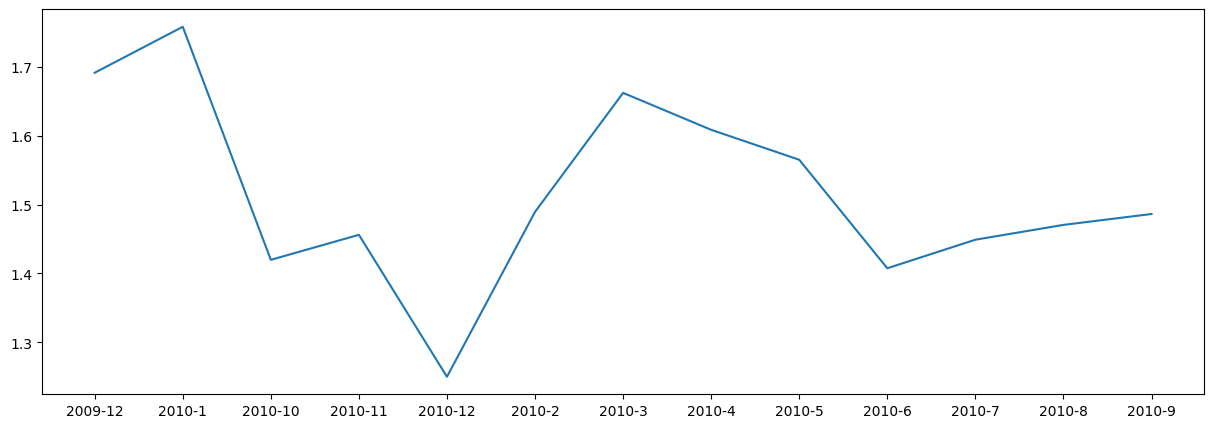

In [30]:
# plot price by date on x axis for stockcode 20979
plt.figure(figsize=(15,5))
plt.plot(train[train['StockCode'] == 20979].groupby('YearMonth')['Price'].mean())




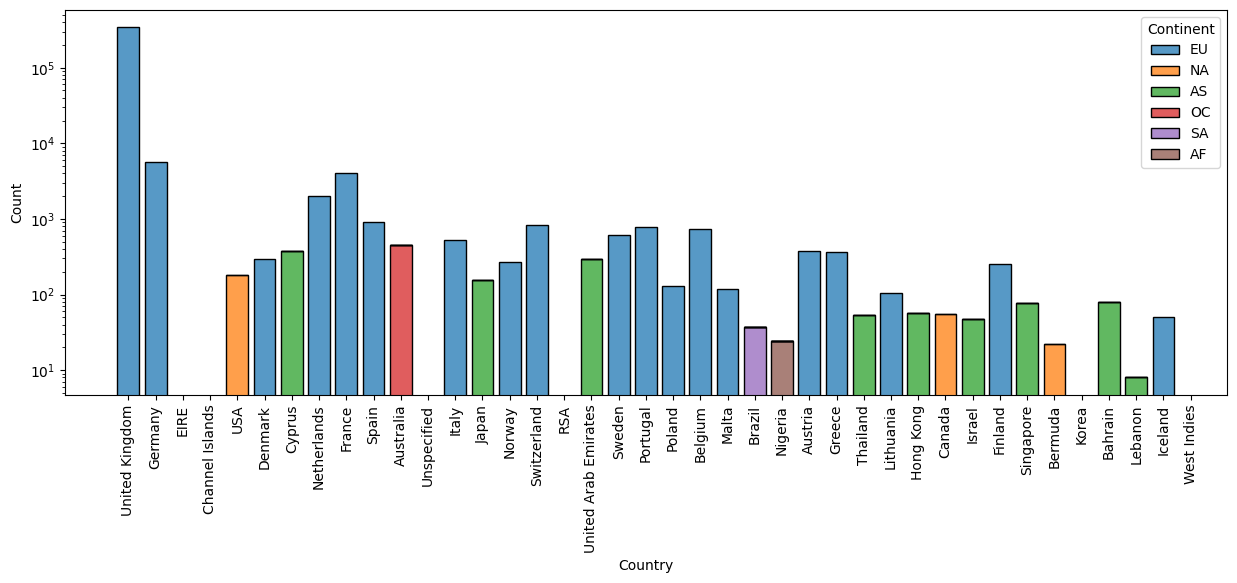

In [86]:
# plot histplot of countries in seaborn color all bars blue make bars sorted by count, color by continent
plt.figure(figsize=(15,5))
sns.histplot(data=train, x='Country', color='blue', multiple='stack', hue='Continent', shrink=0.8)


# scale y logaritmic
plt.yscale('log')

# rotate x labels
plt.xticks(rotation=90)

# sort bars by count

# show plot
plt.show()